In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
import tensorflow as tf

# import 시스템과 상호작용
from importlib.metadata import version

from tensorflow import keras
from matplotlib import pyplot as plt

from tensorflow.keras.layers import (Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Concatenate, LeakyReLU, BatchNormalization, concatenate)
from pixellib.semantic import semantic_segmentation
# pixellib 폴더가서 Pixellib 폴더 -> semantic -> deeplab.py로 이동 
# from tensorflow.python.keras.layers import BatchNormalization를
# from keras.layers.normalization.batch_normalization import BatchNormalization
# 이걸로 바꿔줘야함

##  Step 1. 인물모드 직접 해 보기
--- 

### (1) 인물 사진

(1080, 1080, 3)


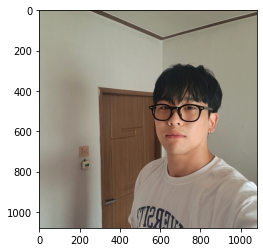

In [58]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/e09_mypicture.png'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [59]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
# Pixellib에서 제공하는 모델 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f2d724273d0>)

In [60]:
model = semantic_segmentation()
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file)

In [61]:
# 이미지 분할, 분할 출력의 배열을 가져옴
# 분할은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path)

In [62]:
# pascalvoc 데이터 라벨종류
label_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(label_names)

21

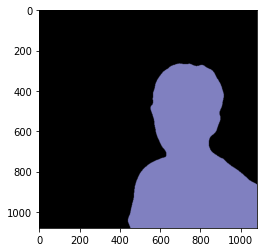

In [63]:
plt.imshow(output)
plt.show()

In [64]:
# 분할 뒤에 나온 배열값
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [65]:
# segvalues에 있는 class_ids에 담겨있는 값을 통해 pacalvoc label 출력
for class_id in segvalues['class_ids']:
    print(label_names[class_id])

background
person


In [66]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [67]:
colormap[15]

array([192, 128, 128])

In [68]:
seg_color = (128,128,192)

(1080, 1080)


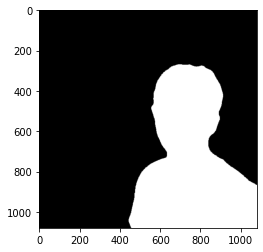

In [69]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

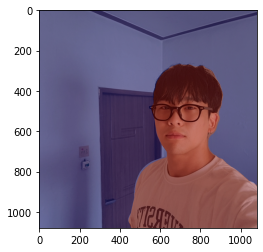

In [70]:
img_show = img_orig.copy()

# True, False인 값을 각각 255와 0으로
img_mask = seg_map.astype(np.uint8) * 255

# 255와 적당한 색상으로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 합치기, 0.4, 0.6은 두 이미지 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

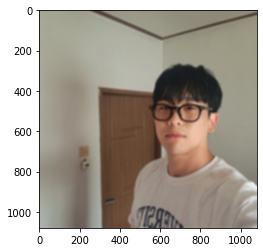

In [71]:
# (13,13)은 blurring kernel size를 뜻함
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

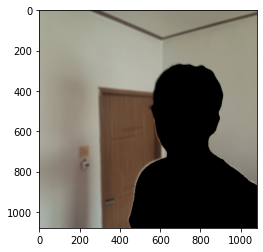

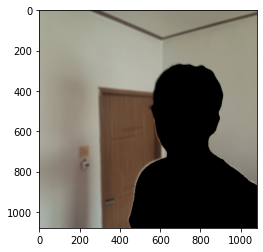

In [72]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됨. 배경0, 사람 255
# 에서 배경 255, 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and() 사용 시 배경만 있는 영상 얻을 수 있음
# 0과 어떤수를 bitwise_and 연산을 해도 0이 되기 때문
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show(())

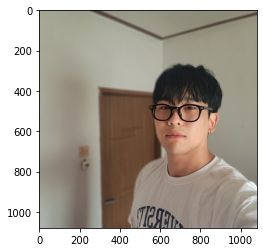

In [73]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2) 고양이 사진

(1387, 1040, 3)


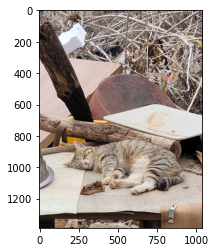

In [75]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image2.jpg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [76]:
segvalues, output = model.segmentAsPascalvoc(img_path)

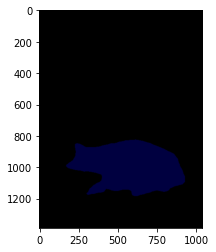

In [77]:
plt.imshow(output)
plt.show()

In [78]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [79]:
for class_id in segvalues['class_ids']:
    print(label_names[class_id])

background
cat


In [80]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [81]:
colormap[8]

array([64,  0,  0])

In [82]:
seg_color = (0,0,64)

(1387, 1040)


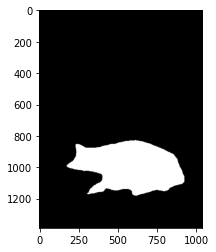

In [83]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

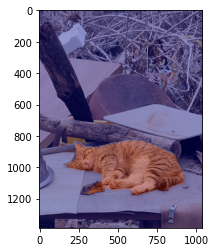

In [84]:
img_show = img_orig.copy()

# True, False인 값을 각각 255와 0으로
img_mask = seg_map.astype(np.uint8) * 255

# 255와 적당한 색상으로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 합치기, 0.4, 0.6은 두 이미지 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

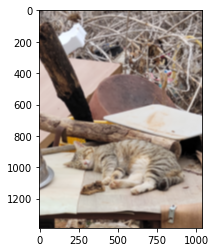

In [85]:
# (13,13)은 blurring kernel size를 뜻함
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

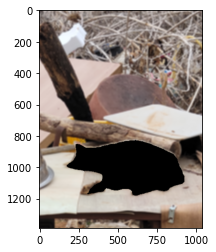

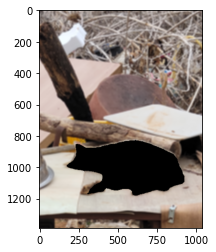

In [86]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됨. 배경0, 사람 255
# 에서 배경 255, 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and() 사용 시 배경만 있는 영상 얻을 수 있음
# 0과 어떤수를 bitwise_and 연산을 해도 0이 되기 때문
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show(())

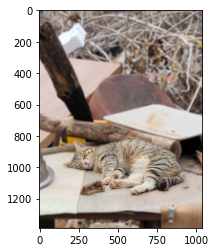

In [87]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3) 크로마키

(461, 700, 3)


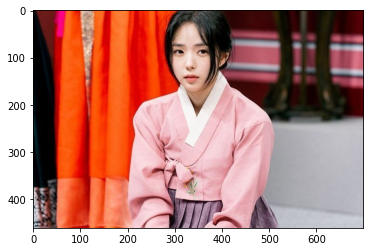

In [89]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/choie2.jfif'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

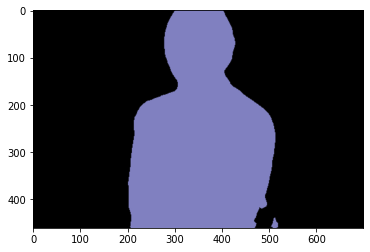

In [90]:
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [91]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [92]:
for class_id in segvalues['class_ids']:
    print(label_names[class_id])

background
person


In [93]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [94]:
colormap[15]

array([192, 128, 128])

In [95]:
seg_color = (128,128,192)

(461, 700)


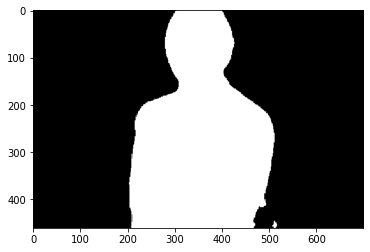

In [96]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

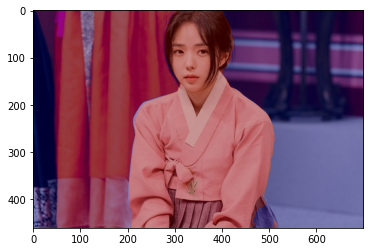

In [97]:
img_show = img_orig.copy()

# True, False인 값을 각각 255와 0으로
img_mask = seg_map.astype(np.uint8) * 255

# 255와 적당한 색상으로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 합치기, 0.4, 0.6은 두 이미지 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(461, 700, 3)


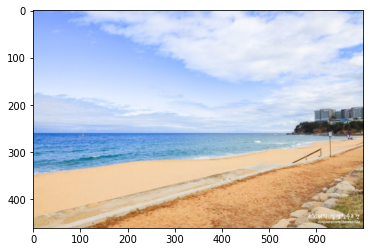

In [106]:
background_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background3.jfif'
background_orig = cv2.imread(background_path)
background_orig = cv2.resize(background_orig, (700,461))
print(background_orig.shape)

plt.imshow(cv2.cvtColor(background_orig, cv2.COLOR_BGR2RGB))
plt.show()

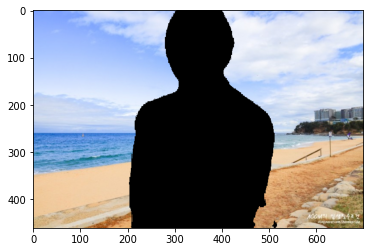

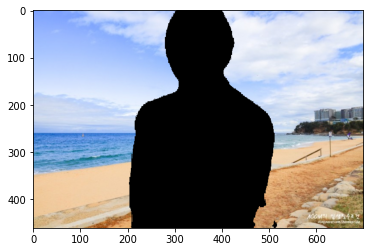

In [107]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됨. 배경0, 사람 255
# 에서 배경 255, 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and() 사용 시 배경만 있는 영상 얻을 수 있음
# 0과 어떤수를 bitwise_and 연산을 해도 0이 되기 때문
background_orig = cv2.bitwise_and(background_orig, img_bg_mask)
plt.imshow(cv2.cvtColor(background_orig, cv2.COLOR_BGR2RGB))
plt.show(())

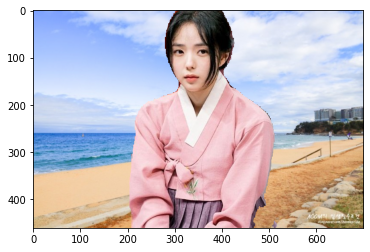

In [108]:
img_concat = np.where(img_mask_color==255, img_orig, background_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기
--- 

### 문제점 1

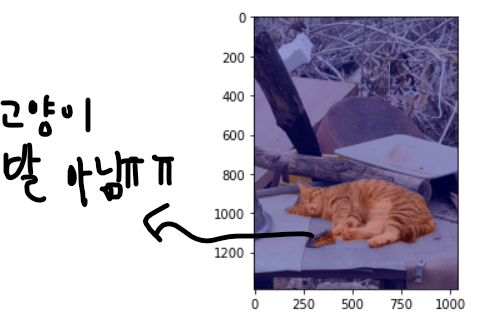

2번째 동물 사진 그림 중 고양이발 밑에 나무 조각까지 고양이라 분류됬다

### 문제점 2

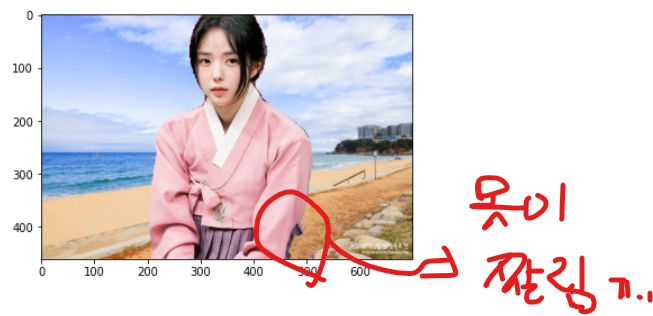

3번째 크로마키 사진 중 채수빈님이 입고있는 치마쪽이 좀 짤려서 나왔다. 전부 한 개체라고 인식하지 못한 것.

## Step 3. 해결 방법을 제안해 보기
---

### 문제점 1 해결방안

고양이와 나무는 생물과 무생물로 나뉠 수 있다. 따라서 두 개체의 온도 차이가 있을 것으로 예상됨.

구글의 Pixel4에 적외선 카메라가 달려있는 것 처럼 적외선으로 얻은 사진과 가시광선으로 얻은 사진 둘 다 segmentation을 진행하고 이 둘 사진 비율을 조정해서 최종 mask를 결정하면 생물 개체만 뽑는 데에 도움이 될 것 같다. 

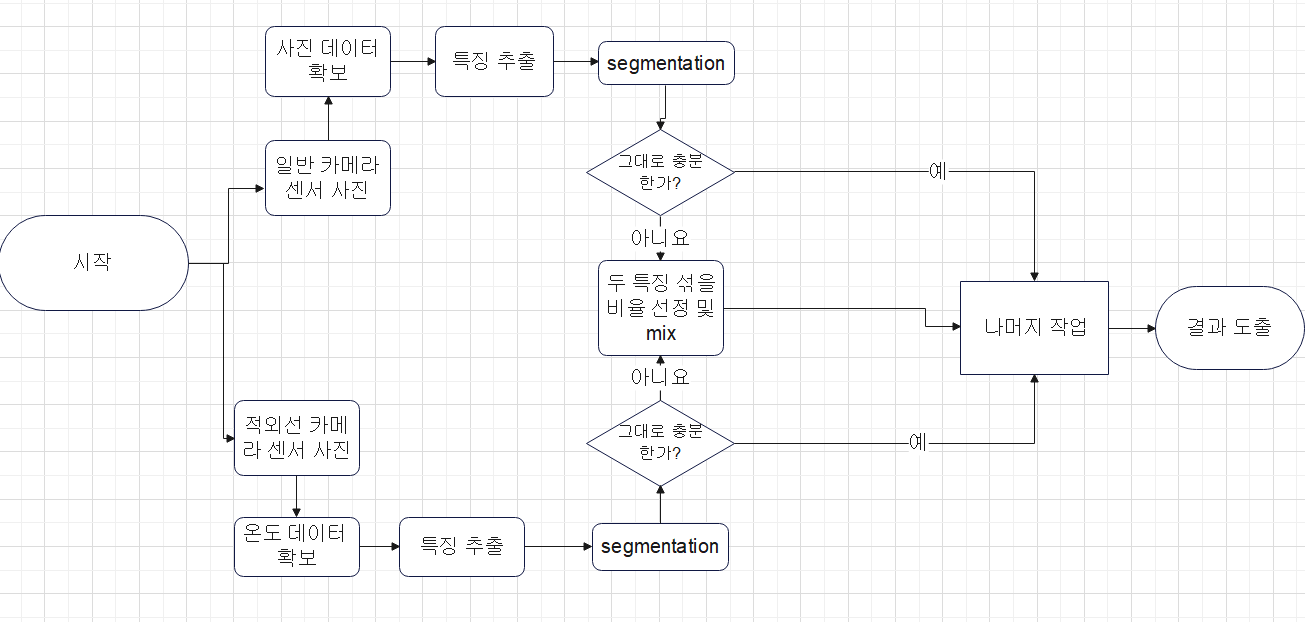

### 문제점 2 해결방안

3D 카메라 센서를 이용한다.D-ToF나 LADAR 센서를 이용해 펄스가 돌아오는 시간 차이를 통해서 인물과 물체를 3D로 인식할 수 있어 문제 3번 사진의 치마 끝자락을 background가 아닌 사람 개체로 분할 해내는 데에 도움이 될 것 같다. 사진의 픽셀값으로 이미지를 나타내듯 사진 크기 만큼의 픽셀값들에 펄스가 돌아온 시간값들을 넣고 Depth estimator를 진행한다. 그리고 일반 사진 이미지에서 얻은 특징들과 실험을 통해 적절한 비율을 선정하고 섞어주어 최종 결과물을 도출한다. SPAD소자를 이용하기 때문에 미세 mm~cm까지 거리 구별이 가능해 심도분해능을 얻을 수 있어 한 개체와 다른 개체가 뒤로 떨어져있는지 아닌지를 분간해 낼 수 있을 것 같다.

문제 1에 만든 순서도와 비슷하게 일반 카메라 사진과 3D 센서를 통해 colormap과 거리 특징을 구한다. 하나가 충분하면 그대로 사용하고 아니라면 둘을 실험에 통해 비율을 선정하고 섞어 딥러닝을 통해 특징을 다시 추출해준다. 그리고 다시 mask를 생성해 분할한다.

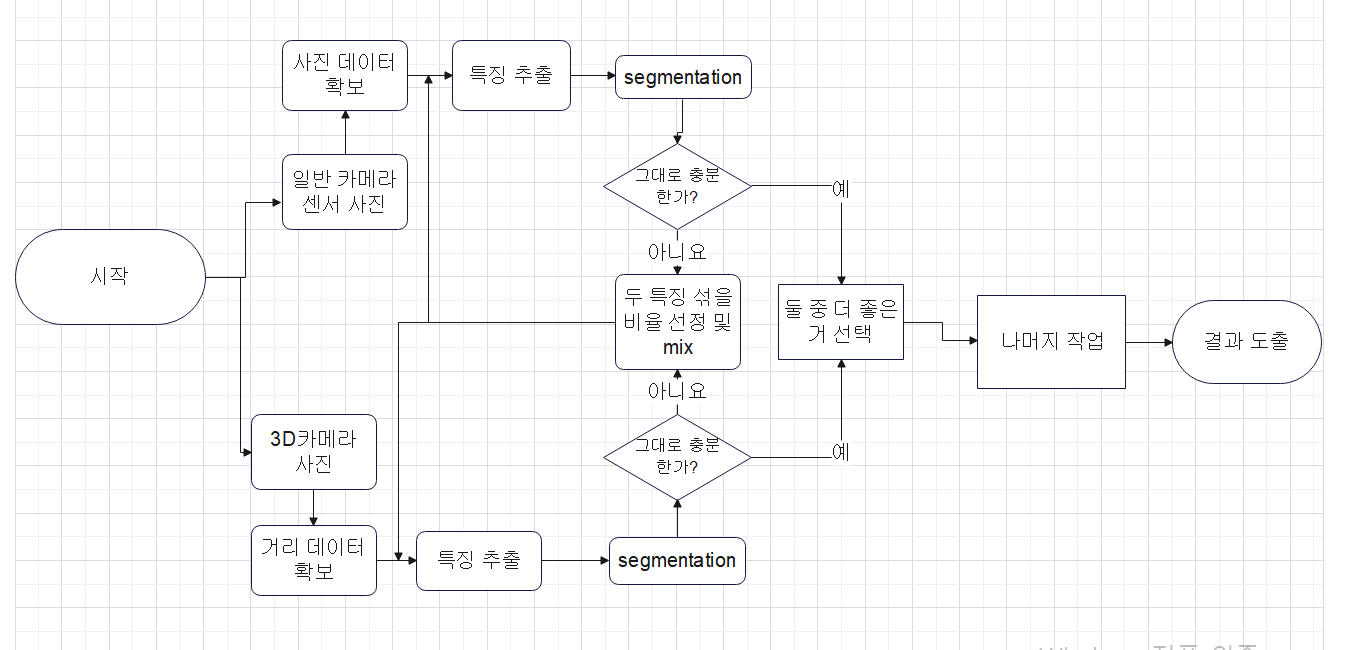